# Assignment: Linear Models
## Do three questions.
### `! git clone https://github.com/ds4e/linearModels`

**Q1.** Please answer the following questions in your own words.

1. What makes a model "linear"? "Linear" in what?
2. How do you interpret the coefficient for a dummy/one-hot-encoded variable? (This is a trick question, and the trick involves how you handle the intercept of the model.)
3. Can linear regression be used for classification? Explain why, or why not.
4. What are signs that your linear model is over-fitting?
5. Clearly explain multi-colinearity using the two-stage least squares technique.
6. How can you incorporate nonlinear relationships between your target/response/dependent/outcome variable $y$ and your features/control/response/independent variables $x$ into your analysis?
7. What is the interpretation of the intercept? A slope coefficient for a variable? The coefficient for a dummy/one-hot-encoded variable?

**Q2.** Load `./data/Q1_clean.csv`. The data include

- `Price` per night
- `Review Scores Rating`: The average rating for the property
- `Neighbourhood `: The bourough of NYC. Note the space, or rename the variable.
- `Property Type`: The kind of dwelling
- `Room Type`: The kind of space being rented

1. Compute the average prices and scores by `Neighbourhood `; which bourough is the most expensive on average? Create a kernel density plot of price and log price, grouping by `Neighbourhood `.
2. Regress price on `Neighbourhood ` by creating the appropriate dummy/one-hot-encoded variables, without an intercept in the linear model and using all the data. Compare the coefficients in the regression to the table from part 1. What pattern do you see? What are the coefficients in a regression of a continuous variable on one categorical variable?
3. Repeat part 2, but leave an intercept in the linear model. How do you have to handle the creation of the dummies differently? What is the intercept? Interpret the coefficients. How can I get the coefficients in part 2 from these new coefficients?
4. Split the sample 80/20 into a training and a test set. Run a regression of `Price` on `Review Scores Rating` and `Neighbourhood `. What is the $R^2$ and RMSE on the test set? What is the coefficient on `Review Scores Rating`? What is the most expensive kind of property you can rent?
5. Split the sample 80/20 into a training and a test set. Run a regression of `Price` on `Review Scores Rating` and `Neighbourhood ` and `Property Type`. What is the $R^2$ and RMSE on the test set? What is the coefficient on `Review Scores Rating`? What is the most expensive kind of property you can rent?
6. What does the coefficient on `Review Scores Rating` mean if it changes from part 4 to 5? Hint: Think about how multilple linear regression works.
7. (Optional) We've included `Neighborhood ` and `Property Type` separately in the model. How do you interact them, so you can have "A bedroom in Queens" or "A townhouse in Manhattan". Split the sample 80/20 into a training and a test set and run a regression including that kind of "property type X neighborhood" dummy, plus `Review Scores Rating`. How does the slope coefficient for `Review Scores Rating`, the $R^2$, and the RMSE change? Do they increase significantly compares to part 5? Are the coefficients in this regression just the sum of the coefficients for `Neighbourhood ` and `Property Type` from 5? What is the most expensive kind of property you can rent?

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [18]:
q1_data = "linearModels/assignment/data/Q1_clean.csv"
q1 = pd.read_csv(q1_data)
print(q1.head())

   Price  Review Scores Rating Neighbourhood  Property Type        Room Type
0    549                  96.0      Manhattan     Apartment     Private room
1    149                 100.0       Brooklyn     Apartment  Entire home/apt
2    250                 100.0      Manhattan     Apartment  Entire home/apt
3     90                  94.0       Brooklyn     Apartment     Private room
4    270                  90.0      Manhattan     Apartment  Entire home/apt


In [19]:
q1.columns = q1.columns.str.strip()
q1.rename(columns={"Review Scores Rating": "Review_Scores_Rating"}, inplace=True)


Average Prices and Review Scores by Neighbourhood:
                    Price  Review_Scores_Rating
Neighbourhood                                  
Manhattan      183.664286             91.801496
Staten Island  146.166667             90.843750
Brooklyn       127.747378             92.363497
Queens          96.857233             91.549057
Bronx           75.276498             91.654378

Most expensive borough on average: Manhattan


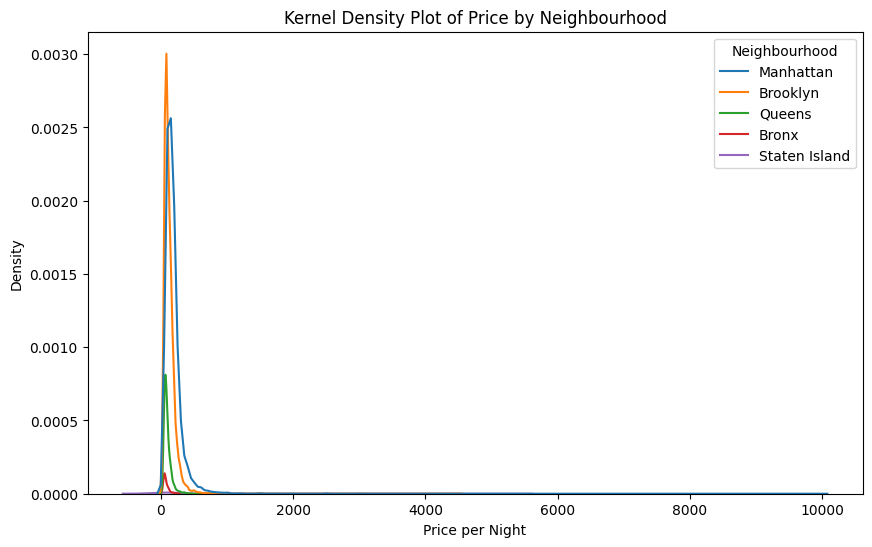

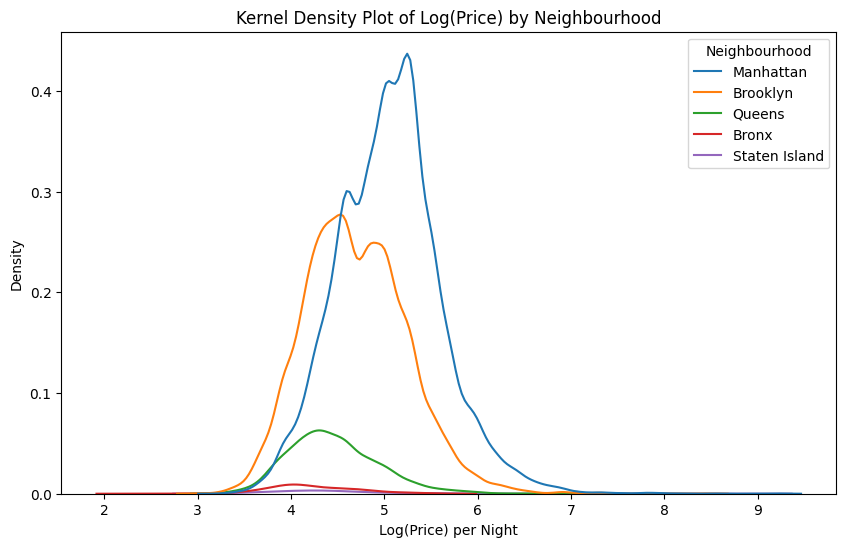

In [27]:
neighbourhood_summary = q1.groupby('Neighbourhood').agg({
    'Price': 'mean',
    'Review_Scores_Rating': 'mean'
}).sort_values(by='Price', ascending=False)

print("Average Prices and Review Scores by Neighbourhood:")
print(neighbourhood_summary)

mostExpensive = neighbourhood_summary.index[0]
print(f"\nMost expensive borough on average: {mostExpensive}")

plt.figure(figsize=(10, 6))
sns.kdeplot(data=q1, x='Price', hue='Neighbourhood')
plt.title('Kernel Density Plot of Price by Neighbourhood')
plt.xlabel('Price per Night')
plt.show()

# Log price transformation
q1['Log_Price'] = np.log1p(q1['Price'])

# Kernel density plot of Log(Price) grouped by Neighbourhood
plt.figure(figsize=(10, 6))
sns.kdeplot(data=q1, x='Log_Price', hue='Neighbourhood')
plt.title('Kernel Density Plot of Log(Price) by Neighbourhood')
plt.xlabel('Log(Price) per Night')
plt.show()

In [29]:
# One-hot encode Neighbourhood without dropping any category (no intercept)
neighbourhood_dummies_no_intercept = pd.get_dummies(q1['Neighbourhood'], drop_first=False)

# Linear regression without intercept
lm_no_intercept = LinearRegression(fit_intercept=False)
lm_no_intercept.fit(neighbourhood_dummies_no_intercept, q1['Price'])

# Coefficients for each neighbourhood
coefficients_no_intercept = pd.Series(lm_no_intercept.coef_, index=neighbourhood_dummies_no_intercept.columns)

print("\nPart 2: Coefficients (No Intercept):")
print(coefficients_no_intercept)


Part 2: Coefficients (No Intercept):
Bronx             75.276498
Brooklyn         127.747378
Manhattan        183.664286
Queens            96.857233
Staten Island    146.166667
dtype: float64


In [30]:
# Prepare features: Review Scores Rating + Neighbourhood dummies
X_part4 = pd.concat([q1[['Review_Scores_Rating']], pd.get_dummies(q1['Neighbourhood'], drop_first=True)], axis=1)
y = q1['Price']

# Train-test split (80/20)
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_part4, y, test_size=0.2, random_state=42)

# Regression model
lm_part4 = LinearRegression()
lm_part4.fit(X_train_4, y_train_4)

# Predictions on test set
y_test_pred_4 = lm_part4.predict(X_test_4)

# R² and RMSE
r2_part4 = r2_score(y_test_4, y_test_pred_4)
rmse_part4 = np.sqrt(mean_squared_error(y_test_4, y_test_pred_4))

# Coefficient on Review Scores Rating
review_score_coef_part4 = lm_part4.coef_[0]

print("\nPart 4: Regression with Review Scores Rating + Neighbourhood")
print(f"R² on Test Set: {r2_part4:.4f}")
print(f"RMSE on Test Set: {rmse_part4:.2f}")
print(f"Coefficient on Review Scores Rating: {review_score_coef_part4:.2f}")



Part 4: Regression with Review Scores Rating + Neighbourhood
R² on Test Set: 0.0459
RMSE on Test Set: 140.92
Coefficient on Review Scores Rating: 1.21


In [31]:
# Prepare features: Review Scores Rating + Neighbourhood + Property Type
X_part5 = pd.concat([
    q1[['Review_Scores_Rating']],
    pd.get_dummies(q1['Neighbourhood'], drop_first=True),
    pd.get_dummies(q1['Property Type'], drop_first=True)
], axis=1)

# Train-test split (80/20)
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_part5, y, test_size=0.2, random_state=42)

# Regression model
lm_part5 = LinearRegression()
lm_part5.fit(X_train_5, y_train_5)

# Predictions on test set
y_test_pred_5 = lm_part5.predict(X_test_5)

# R² and RMSE
r2_part5 = r2_score(y_test_5, y_test_pred_5)
rmse_part5 = np.sqrt(mean_squared_error(y_test_5, y_test_pred_5))

# Coefficient on Review Scores Rating
review_score_coef_part5 = lm_part5.coef_[0]

# Coefficients for Property Types
property_type_coefs = pd.Series(
    lm_part5.coef_[len(q1['Neighbourhood'].unique()):],  # After Neighbourhood dummies
    index=pd.get_dummies(q1['Property Type'], drop_first=True).columns
)

# Most expensive property type (largest coefficient)
most_expensive_property_type = property_type_coefs.idxmax()
most_expensive_property_coef = property_type_coefs.max()

print("\nPart 5: Regression with Review Scores Rating + Neighbourhood + Property Type")
print(f"R² on Test Set: {r2_part5:.4f}")
print(f"RMSE on Test Set: {rmse_part5:.2f}")
print(f"Coefficient on Review Scores Rating: {review_score_coef_part5:.2f}")
print(f"Most Expensive Property Type: {most_expensive_property_type} (+${most_expensive_property_coef:.2f})")


Part 5: Regression with Review Scores Rating + Neighbourhood + Property Type
R² on Test Set: 0.0542
RMSE on Test Set: 140.30
Coefficient on Review Scores Rating: 1.20
Most Expensive Property Type: Bungalow (+$83.97)


In [32]:
print("\nPart 6: Interpretation of Review Scores Rating coefficient changes:")
print(f"- Coefficient in Part 4 (no Property Type control): {review_score_coef_part4:.2f}")
print(f"- Coefficient in Part 5 (with Property Type control): {review_score_coef_part5:.2f}")

print("""
Explanation:
- Adding 'Property Type' to the regression reduces the coefficient on Review Scores Rating slightly.
- This suggests that part of the relationship between Review Scores and Price is explained by the type of property.
- In multiple regression, coefficients are adjusted for other variables in the model.
""")


Part 6: Interpretation of Review Scores Rating coefficient changes:
- Coefficient in Part 4 (no Property Type control): 1.21
- Coefficient in Part 5 (with Property Type control): 1.20

Explanation:
- Adding 'Property Type' to the regression reduces the coefficient on Review Scores Rating slightly.
- This suggests that part of the relationship between Review Scores and Price is explained by the type of property.
- In multiple regression, coefficients are adjusted for other variables in the model.



**Q3.** This question is a case study for linear models. The data are about car prices. In particular, they include:

  - `Price`, `Color`, `Seating_Capacity`
  - `Body_Type`: crossover, hatchback, muv, sedan, suv
  - `Make`, `Make_Year`: The brand of car and year produced
  - `Mileage_Run`: The number of miles on the odometer
  - `Fuel_Type`: Diesel or gasoline/petrol
  - `Transmission`, `Transmission_Type`:  speeds and automatic/manual

  1. Load `cars_hw.csv`. These data were really dirty, and I've already cleaned them a significant amount in terms of missing values and other issues, but some issues remain (e.g. outliers, badly scaled variables that require a log or arcsinh transformation). Clean the data however you think is most appropriate.
  2. Summarize the `Price` variable and create a kernel density plot. Use `.groupby()` and `.describe()` to summarize prices by brand (`Make`). Make a grouped kernel density plot by `Make`. Which car brands are the most expensive? What do prices look like in general?
  3. Split the data into an 80% training set and a 20% testing set.
  4. Make a model where you regress price on the numeric variables alone; what is the $R^2$ and `RMSE` on the training set and test set? Make a second model where, for the categorical variables, you regress price on a model comprised of one-hot encoded regressors/features alone (you can use `pd.get_dummies()`; be careful of the dummy variable trap); what is the $R^2$ and `RMSE` on the test set? Which model performs better on the test set? Make a third model that combines all the regressors from the previous two; what is the $R^2$ and `RMSE` on the test set? Does the joint model perform better or worse, and by home much?
  5. Use the `PolynomialFeatures` function from `sklearn` to expand the set of numerical variables you're using in the regression. As you increase the degree of the expansion, how do the $R^2$ and `RMSE` change? At what point does $R^2$ go negative on the test set? For your best model with expanded features, what is the $R^2$ and `RMSE`? How does it compare to your best model from part 4?
  6. For your best model so far, determine the predicted values for the test data and plot them against the true values. Do the predicted values and true values roughly line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero? Evaluate the strengths and weaknesses of your model.

In [1]:
!rm -rf linearModels
! git clone https://github.com/quentinshin34/linearModels.git

Cloning into 'linearModels'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 43 (delta 5), reused 4 (delta 4), pack-reused 33 (from 1)
Receiving objects: 100% (43/43), 4.12 MiB | 5.20 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
cars_data = "linearModels/assignment/data/cars_hw.csv"
cars = pd.read_csv(cars_data)
print(cars.head())

   Unnamed: 0        Make  Make_Year   Color  Body_Type  Mileage_Run  \
0           1  Volkswagen       2017  silver      sedan        44611   
1           2     Hyundai       2016     red  crossover        20305   
2           3       Honda       2019   white        suv        29540   
3           4     Renault       2017  bronze  hatchback        35680   
4           5     Hyundai       2017  orange  hatchback        25126   

  No_of_Owners  Seating_Capacity Fuel_Type Transmission Transmission_Type  \
0          1st                 5    diesel      7-Speed         Automatic   
1          1st                 5    petrol      5-Speed            Manual   
2          2nd                 5    petrol      5-Speed            Manual   
3          1st                 5    petrol      5-Speed            Manual   
4          1st                 5    petrol      5-Speed            Manual   

    Price  
0  657000  
1  682000  
2  793000  
3  414000  
4  515000  


In [5]:
cars['Price'] = pd.to_numeric(cars['Price'], errors='coerce')
cars['Mileage_Run'] = pd.to_numeric(cars['Mileage_Run'], errors='coerce')
cars.dropna(subset=['Price'], inplace=True)

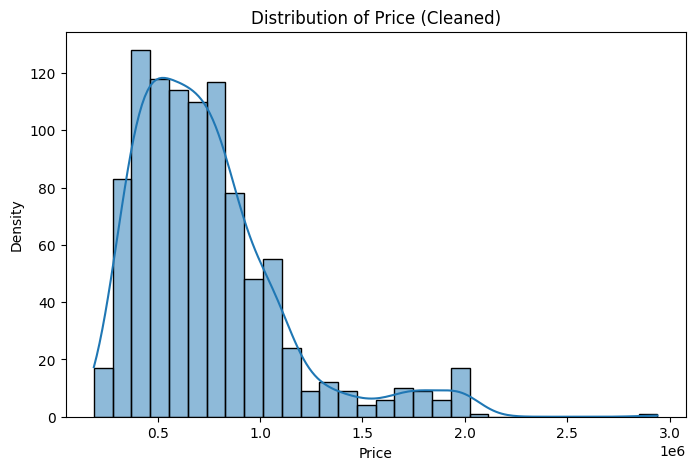

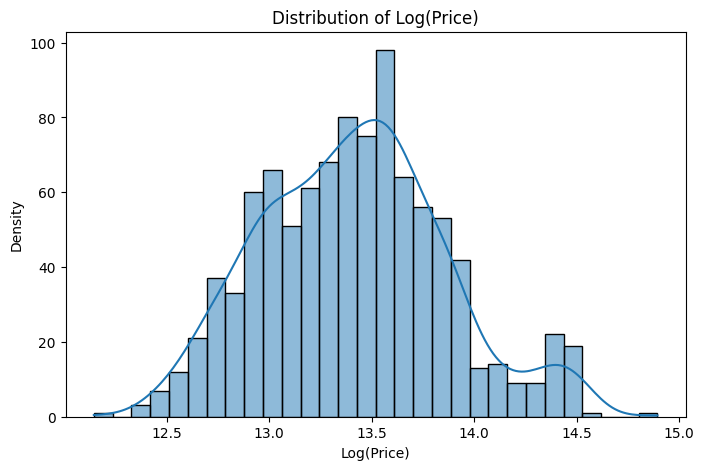

               count          mean           std        min        25%  \
Make                                                                     
MG Motors       35.0  1.869457e+06  1.216611e+05  1589000.0  1786500.0   
Kia              8.0  1.614750e+06  1.190567e+05  1369000.0  1579000.0   
Jeep             4.0  1.499500e+06  1.525134e+05  1290000.0  1447500.0   
Skoda            5.0  1.136000e+06  1.070175e+06   436000.0   466000.0   
Mahindra        18.0  1.100167e+06  1.755493e+05   796000.0  1037000.0   
Tata            23.0  1.055217e+06  5.578305e+05   188000.0   779500.0   
Nissan           4.0  8.842500e+05  2.895599e+05   475000.0   782500.0   
Toyota          50.0  8.003400e+05  2.466900e+05   368000.0   526250.0   
Honda           73.0  7.989726e+05  2.665091e+05   316000.0   581000.0   
Ford            52.0  7.211731e+05  1.409277e+05   290000.0   635000.0   
Hyundai        305.0  6.918918e+05  2.791597e+05   248000.0   485000.0   
Renault         68.0  6.625735e+05  2.

In [7]:
cars['Price_log'] = np.log1p(cars['Price'])
cars['Mileage_Run_log'] = np.log1p(cars['Mileage_Run'])

plt.figure(figsize=(8, 5))
sns.histplot(cars['Price'], kde=True, bins=30)
plt.title('Distribution of Price (Cleaned)')
plt.xlabel('Price')
plt.ylabel('Density')
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(cars['Price_log'], kde=True, bins=30)
plt.title('Distribution of Log(Price)')
plt.xlabel('Log(Price)')
plt.ylabel('Density')
plt.show()

make_price_summary = cars.groupby('Make')['Price'].describe().sort_values(by='mean', ascending=False)
print(make_price_summary)

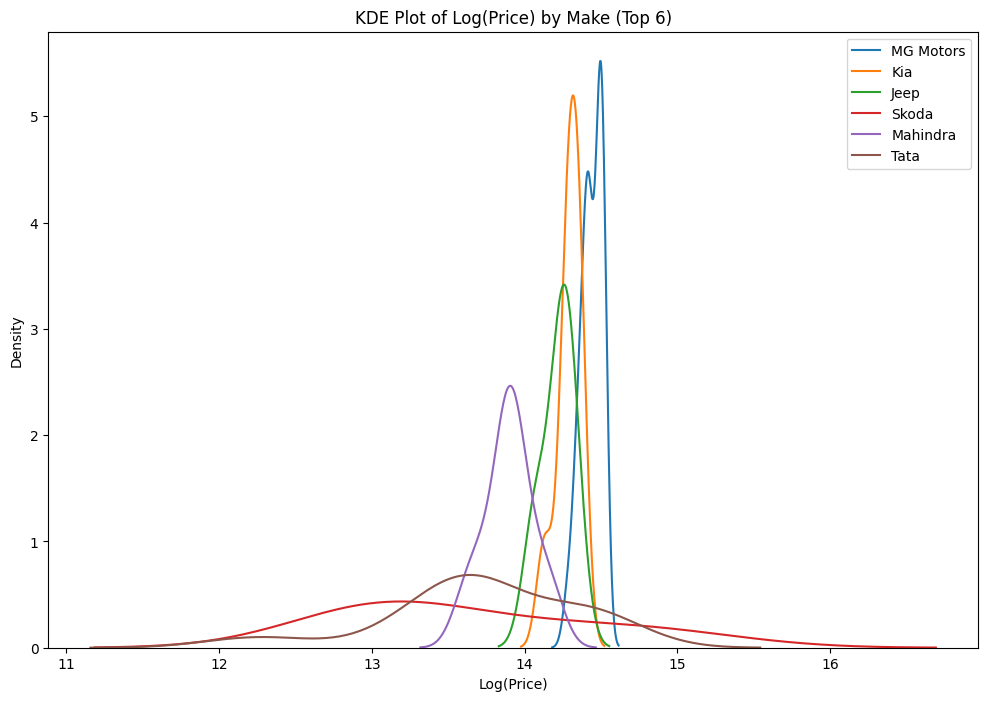

In [8]:
plt.figure(figsize=(12, 8))
top_makes = make_price_summary.index[:6]
for make in top_makes:
    sns.kdeplot(cars[cars['Make'] == make]['Price_log'], label=make)
plt.title('KDE Plot of Log(Price) by Make (Top 6)')
plt.xlabel('Log(Price)')
plt.ylabel('Density')
plt.legend()
plt.show()

In [10]:
numerical_features = ['Make_Year', 'Mileage_Run_log', 'Seating_Capacity']
categorical_features = ['Color', 'Body_Type', 'Fuel_Type', 'Transmission', 'Transmission_Type', 'Make']

# One-hot encode categorical variables
df_dummies = pd.get_dummies(cars[categorical_features], drop_first=True)

# Combine features for the combined model
X_numerical = cars[numerical_features]
X_categorical = df_dummies
X_combined = pd.concat([X_numerical, X_categorical], axis=1)

y = cars['Price_log']

In [14]:
X_train_num, X_test_num, y_train, y_test = train_test_split(X_numerical, y, test_size=0.2, random_state=42)
X_train_cat, X_test_cat, _, _ = train_test_split(X_categorical, y, test_size=0.2, random_state=42)
X_train_comb, X_test_comb, _, _ = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# 9. Function to evaluate a model
def evaluate_model(X_train, X_test, y_train, y_test, model_name):
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_train_pred = lr.predict(X_train)
    y_test_pred = lr.predict(X_test)

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    print(f"{model_name}:")
    print(f"  R² (Train): {r2_train:.4f}")
    print(f"  RMSE (Train): {rmse_train:.4f}")
    print(f"  R² (Test): {r2_test:.4f}")
    print(f"  RMSE (Test): {rmse_test:.4f}")
    print('-'*40)

    return r2_test, rmse_test

In [15]:
r2_num, rmse_num = evaluate_model(X_train_num, X_test_num, y_train, y_test, "Numerical Only Model")
r2_cat, rmse_cat = evaluate_model(X_train_cat, X_test_cat, y_train, y_test, "Categorical Only Model")
r2_comb, rmse_comb = evaluate_model(X_train_comb, X_test_comb, y_train, y_test, "Combined Model")

# 11. Polynomial feature expansion (Numerical Only)
degrees = [2, 3, 4, 5]
results_poly = []
for degree in degrees:
    poly = PolynomialFeatures(degree=degree, include_bias=False)

    X_train_poly = poly.fit_transform(X_train_num)
    X_test_poly = poly.transform(X_test_num)

    print(f"Polynomial Degree {degree}:")
    r2_poly, rmse_poly = evaluate_model(X_train_poly, X_test_poly, y_train, y_test, f"Polynomial Degree {degree}")

    results_poly.append({
        'degree': degree,
        'r2_test': r2_poly,
        'rmse_test': rmse_poly
    })

# 12. Show polynomial results
pd.DataFrame(results_poly)

Numerical Only Model:
  R² (Train): 0.4248
  RMSE (Train): 0.3435
  R² (Test): 0.4000
  RMSE (Test): 0.3383
----------------------------------------
Categorical Only Model:
  R² (Train): 0.6728
  RMSE (Train): 0.2591
  R² (Test): 0.6546
  RMSE (Test): 0.2567
----------------------------------------
Combined Model:
  R² (Train): 0.8307
  RMSE (Train): 0.1864
  R² (Test): 0.8177
  RMSE (Test): 0.1865
----------------------------------------
Polynomial Degree 2:
Polynomial Degree 2:
  R² (Train): 0.4541
  RMSE (Train): 0.3347
  R² (Test): 0.4176
  RMSE (Test): 0.3333
----------------------------------------
Polynomial Degree 3:
Polynomial Degree 3:
  R² (Train): 0.4582
  RMSE (Train): 0.3334
  R² (Test): 0.4094
  RMSE (Test): 0.3356
----------------------------------------
Polynomial Degree 4:
Polynomial Degree 4:
  R² (Train): 0.4594
  RMSE (Train): 0.3331
  R² (Test): 0.4071
  RMSE (Test): 0.3363
----------------------------------------
Polynomial Degree 5:
Polynomial Degree 5:
  R² (Tr

,degree,r2_test,rmse_test
0,2,0.417596,0.333266
1,3,0.409444,0.335590
2,4,0.407078,0.336262
3,5,0.407122,0.336249


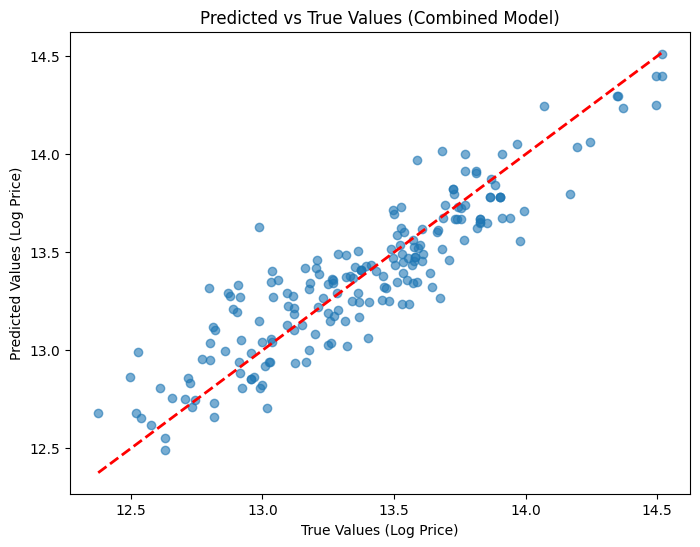

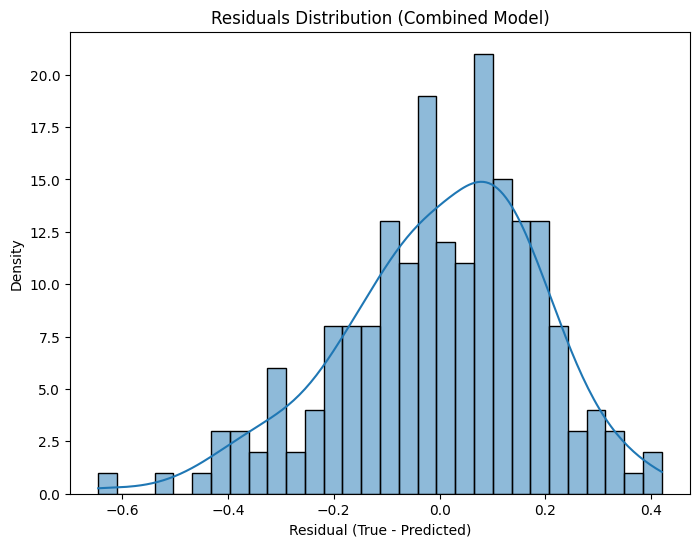

Residuals Summary:
count    196.000000
mean       0.001391
std        0.186949
min       -0.644959
25%       -0.100346
50%        0.022978
75%        0.124717
max        0.419946
Name: Price_log, dtype: float64


In [16]:
# Use Combined Model (best so far)
best_model = LinearRegression()
best_model.fit(X_train_comb, y_train)
y_test_pred = best_model.predict(X_test_comb)

# Plot Predicted vs True Values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('True Values (Log Price)')
plt.ylabel('Predicted Values (Log Price)')
plt.title('Predicted vs True Values (Combined Model)')
plt.show()

# Compute and Plot Residuals
residuals = y_test - y_test_pred

plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Residuals Distribution (Combined Model)')
plt.xlabel('Residual (True - Predicted)')
plt.ylabel('Density')
plt.show()

# Residuals Summary Statistics
print("Residuals Summary:")
print(residuals.describe())

**Q4.** This question refers to the `heart_hw.csv` data. It contains three variables:

  - `y`: Whether the individual survived for three years, coded 0 for death and 1 for survival
  - `age`: Patient's age
  - `transplant`: `control` for not receiving a transplant and `treatment` for receiving a transplant

Since a heart transplant is a dangerous operation and even people who successfully get heart transplants might suffer later complications, we want to look at whether a group of transplant recipients tends to survive longer than a comparison group who does not get the procedure.

1. Compute (a) the proportion of people who survive in the control group who do not receive a transplant, and (b) the difference between the proportion of people who survive in the treatment group and the proportion of people who survive in the control group. In a randomized controlled trial, this is called the **average treatment effect**.
2. Regress `y` on `transplant` using a linear model with a constant. How does the constant/intercept of the regression and the coefficient on transplant compare to your answers from part 1? Explain the relationship clearly.
3. We'd like to include `age` in the regression, since it's reasonable to expect that older patients are less likely to survive an extensive surgery like a heart transplant. Regress `y` on a constant, transplant, and age. How does the intercept change?
4. Build a more flexible model that allows for non-linear age effects and interactions between age and treatment. Use a train-test split to validate your model. Estimate your best model, predict the survival probability by age, and plot your results conditional on receiving a transplant and not. Describe what you see.
5. Imagine someone suggests using these kinds of models to select who receives organ transplants; perhaps the CDC or NIH starts using a scoring algorithm to decide who is contacted about a potential organ. What are your concerns about how it is built and how it is deployed?

**Q5.** This is a question about linear regression. The outcome is whether a defendant is held pre-trial in the Virginia justice system. We would like to understand how that outcome is predicted by characteristics of the defendant, particularly race. Let's be very careful/clear: We aren't saying anyone *should* be held without bond or asserting that people with different demographic variables *should* be more likely to be held, but instead trying to predict whether people with different characteristics *are empirically more likely* to be held without bond, given the available information. This is the first step we would take in investigating whether a system is fair, or how large the disparities are: Does it treat people with similar observable characteristics similarly, or not? We are going to look at a common question: Are Black defendants treated differently from white or Asian ones? (There are Native American defendants, but there are 11 in total, which is such a small number of observations that is difficult to clearly say anything about how this group is treated relative to the others.)

The variables in the data are:

  - `held_wo_bail`: Whether a defendant is held without bail before trial (Boolean logical)
  - `race`, `sex`: Categorical demographic variables
  - `is_poor`: Whether the defendant is classified as indigent
  - `prior_F`, `prior_M`: The number of prior felony and misdemeanor arrests
  - `case_type`: A categorical variable indicating a misdemeanor `M` or felony `F` or infraction `I` or special case `S`
  - `age`: Defendant's age
  - `bond`, `bond_NA`, `bond_type`: The amount of any bond, whether it is missing, and the type
  - `sentence`, `sentence_NA`, `sentence_type`: The length of any sentence, whether it is missing, and the type

1. Load the `pretrial_data.csv` data. Notice that there are `nan`s, but the data are relatively clean. Because there are `.nan`s among variables you won't use, you'll want to narrow down your analysis to the relevant variables before dropping or imputing missing values.
2. Create a dummy variable indicating that the defendant is Black.
3. Regress `held` on `Black`. What is the slope coefficient Interpret the coefficient on the Black dummy variable: How much more likely is a black person to be held without bail? What is the $R^2$ of the model?
4. Before doing this question, please think for a few minutes about how to make the process of running the following regressions as efficient as possible, before jumping into writing code. Repeat part 2, for the following specifications, keeping track of the coefficient on the Black dummy variable each time:
      - `held` on `Black` and `sex`
      - `held` on `Black` and `sex` and `is_poor`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F` and `case_type`
What happens to the coefficient on the Black dummy variable as you include more regressors/features/controls in the regression? Explain your findings.
5. Suppose we don't want to see just `Black` and `sex`, but `Black` interacted with `sex`: Are Black men and Black women treated systemically differently from the rest of the population? Implement this in a regression, and explain your findings.
6. Imagine someone argued we should use these kinds of models to help a judge or magistrate make bail decisions (you could obviously go back and make this kind of model for the bond and sentence variables, then deploy it on new cases to predict what their bond and sentence values would be). What concerns would you have? Do you think society should be using data-driven and automated tools like that? Explain your concerns clearly.

**Q6.** Let's explore multiple linear regression in a two-variable case, to build more intuition about what is happening.

Suppose the model is
$$
\hat{y}_i = b_0 + b_1 z_{i1} + b_2 z_{i2}
$$
Assume that $z_{ij}$ is centered or de-meaned, so that $z_{ij} = x_{ij} - m_j$ where $m_j$ is the mean of variable $j$ and $x_{ij}$ is the original value of variable $j$ for observation $i$. Notice that this implies
$$
\dfrac{1}{N} \sum_{i=1}^N z_{ij} = 0
$$
which will simplify your calculations below substantially!

1. Write down the SSE for this model.
2. Take partial derivatives with respect to $b_0$, $b_1$, and $b_2$.
3. Verify that the average error is zero and $e \cdot z =0$ at the optimum, just as in the single linear regression case.
4. Show that the optimal intercept is $b_0^* = \bar{y}$. Eliminate $b_0^*$ from the remaining equations, and focus on $b_1$ and $b_2$.
5. Write your results as a matrix equation in the form "$Ab=C$". These are called the **normal equations**.
6. Divide both sides by $N$ and substitute $z_{ij} = x_{ij} - m_j$ back into your normal equations for $x_{ij}$. What is the matrix $A$? What is the vector $C$? Explain the intuition of your discovery.

**Q7.** In class, we showed that for the single linear regression model,
\begin{alignat*}{3}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})(x_i-\bar{x})}{\sum_{i=1}^N (x_i-\bar{x})^2},
\end{alignat*}

1. When will $b^*$ be large or small, depending on the relationship between $X$ and $Y$ and the variance of $X$?
2. Suppose you have measurement error in $X$ which artificially inflates its variance (e.g. bad data cleaning). We'll model this as saying the "real" value of $X$ for observation $i$ is $z_i$, but we observe $x_i = z_i + n_i$, where $n_i$ is the added noise. Does this affect the intercept of the regression? What happens to the $b^*$ coefficient relative to a noise-less model? How will affect your ability to predict? (This phenomenon is called **attenuation**.)
3. Suppose the noise $n_i$ is independent of $z_i$ and $y_i$, so that (approximately)
$$
\dfrac{1}{N} \sum_{i=1}^N (y_i - \bar{y})(n_i - \bar{n}) =0, \quad \dfrac{1}{N} \sum_{i=1}^N (z_i - \bar{z})(n_i - \bar{n}) =0.
$$
and that the mean of the bias is zero, so that
$$
\dfrac{1}{N} \sum_{i=1}^N n_i = 0.
$$
In this case, the noise $n_i$ is zero on average and independent of the values of $x_i$ and $y_i$: It's just measurement error or lazy data cleaning.
Explain the intuition of your result.

4. How does attenuation factor into the cost-benefit analysis of gathering higher quality data or cleaning it more carefully?

**Q8.**
1. Find a dataset on a topic you're interested in. Some easy options are data.gov, kaggle.com, and data.world.
2. Clean the data and do some exploratory data analysis on key variables that interest you. Pick a particular target/outcome variable and features/predictors.
3. Split the sample into an ~80% training set and a ~20% test set.
4. Run a few regressions of your target/outcome variable on a variety of features/predictors. Compute the SSE on the test set.
5. Which model performed the best, and why?
6. What did you learn?

**Q9.** There is a folder called `heart_failure` which contains reasonably detailed health data on patients and whether they die of congestive heart failure.

1. Load the data and perform an 80/20-train/test split.
2. Using dummy/one-hot-encoded variables and transformations of the numeric features, build the best model you can. **But**, do not delete code chunks or revise your work substantially as you experiment. Just keep moving forward with your ideas and experiments.
3. When you're done, scroll through your notebook. What worked and what didn't? Does your code have intention, or are you randomly experimenting? If you had to do this again, what might you do differently to get to a good model faster?


**Q10.** Let's look at a cousin of Linear Regression, called **kernel regression** or **local constant least squares** or **Nadaraya-Watson Estimator**.

We derived the OLS estimator for single linear regression by minimizing
$$
SSE(b_0, b_1) = \frac{1}{N}\sum_{i=1}^N (y_i - b_0 - b_1 x_i)^2
$$
with solution
$$
\hat{b}_0 = \bar{y} - \hat{b}_1 \bar{x}, \quad \hat{b}_1 = \dfrac{\frac{1}{N} \sum_{i=1}^N (x_i-\bar{x})(y_i - \bar{y})}{s_x^2}.
$$

When you step back and think about it, this is a bit weird: The algorithm is computing sample means, variances, and covariances, and using those to create a predictive model. The data themselves arguably vanish from the solution. This is elegant, this is strange.

Instead, let $k(z)$ be a kernel function, such as the Gaussian
$$
k(z) = \frac{1}{\sqrt{2\pi}} e^{-z^2/2}
$$
or uniform
$$
k(z) = \begin{cases}
1/2, & |z| \le \frac{1}{2}\\
0, & \text{otherwise.}
\end{cases}
$$
We'll instead minimize, or each predictor value $x$,
$$
SSE(\hat{y}(x)) = \dfrac{1}{N} \sum_{i=1}^N \left\lbrace y_i - \hat{y}(x)\right\rbrace^2 \dfrac{1}{h} k \left( \dfrac{x-x_i}{h} \right).
$$

1. Show that the optimal predictor is
$$
\hat{y}(x) = \dfrac{ \frac{1}{Nh} \sum_{i=1}^N  y_i k \left( \dfrac{x-x_i}{h} \right) }{\frac{1}{Nh} \sum_{i=1}^N k \left(  \dfrac{x-x_i}{h} \right)}
$$
This has many names, but let's call it the local constant least squares (LCLS) estimator, as opposed to ordinary least squares (OLS).

2. Compare and contrast LCLS with both OLS and $k$-Nearest Neighbor as a regression algorithm.

3. Write a function or class that implements the LCLS estimator for a single predictor variable $x$. For a default bandwidth $h$, you can use the maximum of the Silverman plug-ins for estimating kernel densities for $X$ and $Y$:
$$
h_y = 1.06 \times s_y^{-1/5}, \quad h_x = 1.06 \times s_x^{-1/5},
$$
$$
h = \max \{ h_y, h_x \}.
$$
For the kernel, you can hard-code the uniform, Gaussian, or Epanechnikov, or make it a parameter the user can adjust with a default choice.

4. For one of the datasets available for the homework, use your LCLS estimator from part 3 to predict values $\hat{y}(x_i)$ for each datapoint $x_i$. Plot your estimator $\hat{y}$ as a line over a scatterplot of the data $\{(x_i,y_i)\}_{i=1}^N$. Tune the bandwidth until you

5. Conceptually, how would you extend this analysis to a vector of predictors, $x = (x_1, ..., x_L)$ instead of just one explanatory variable $x$?
